In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
colors = sns.color_palette("Paired", n_colors=12).as_hex()

import numpy as np
import torch

from gmm_torch import GaussianMixture
from math import sqrt

In [3]:
!pip install munkres

In [10]:
ls /opt/tta/cmpark_AdaContrast/

__init__.py    losses.py                       target.py
__pycache__/   main_adacontrast.py             torch_clustering/
checkpoint/    media/                          torch_clustering.ipynb
classifier.py  moco/                           train_VISDA-C_source.sh
clustering/    notebook/                       train_VISDA-C_target.sh
configs/       pseudo_label.py                 train_domainnet-126_source.sh
debug/         readme.md                       train_domainnet-126_target.sh
gmm_torch.py   single_train_VISDA-C_target.sh  utils.py
image_list.py  source.py                       val_bank_1.pickle


In [3]:
import numpy as np 
center = np.array([[ 60.570705 ,  38.732014 ],
                   [ 81.979225 , -40.307297 ],
                   [-49.011993 , -45.446415 ],
                   [ -1.703202 , -78.53597  ],
                   [-10.826832 , 103.04519  ],
                   [ 15.872249 ,  11.116764 ],
                   [ 79.46434  , -64.53281  ],
                   [-12.6333885,  64.13071  ],
                   [-47.274757 ,  24.438663 ],
                   [  3.9247844,  32.38488  ],
                   [-85.34527  ,   1.5171984],
                   [-12.429519 , -56.74621  ]],)

In [1]:
import pickle
with open('/opt/tta/cmpark_AdaContrast/val_bank_-1.pickle', 'rb') as f:
    data = pickle.load(f)

In [8]:
from sklearn.manifold import TSNE # sklearn 사용하면 easy !! 
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
from pseudo_label import gmm
from sklearn.mixture import GaussianMixture
# features_o = data['features_o'].cpu().numpy()[:20000]
# tsne = TSNE(n_components=2, random_state=0) # 사실 easy 함 sklearn 사용하니..
# cluster = np.array(tsne.fit_transform(features_o))
# actual = np.array(data['gt'].cpu().numpy())[:20000]

In [4]:

# center = F.normalize(data['probs_o'].T.mm(data['features_o']), dim=1).cpu().numpy()
# feature = data['features_o'].cpu().numpy()
# gt = data['gt'].cpu().numpy()


In [16]:
center_tsne = TSNE(n_components=2,perplexity=11, random_state=0) # 사실 easy 함 sklearn 사용하니..
tsne = TSNE(n_components=2, random_state=0) # 사실 easy 함 sklearn 사용하니..

center_pca = PCA(n_components=2)
pca = PCA(n_components=2)

In [26]:
use_torch_gmm = True 
n_sample = 40000
if use_torch_gmm: 
    
    features_bank = data['features_o'][:n_sample]
    probs_bank = data['probs_o'][:n_sample]
    
    clss_num = probs_bank.size(1)
    uniform = torch.ones(len(features_bank),clss_num)/clss_num
    uniform = uniform.cuda()

    pi = probs_bank.sum(dim=0)
    mu = torch.matmul(probs_bank.t(),(features_bank)) # matrix multiple (F,C) center??
    mu = mu / pi.unsqueeze(dim=-1).expand_as(mu) # normalize first 

    zz, gamma = gmm((features_bank), pi, mu, uniform)
    pred_labels = gamma.argmax(dim=1)
    
    for round in range(1):
        pi = gamma.sum(dim=0)
        mu = torch.matmul(gamma.t(), (features_bank))
        mu = mu / pi.unsqueeze(dim=-1).expand_as(mu)

        zz, gamma = gmm((features_bank), pi, mu, gamma)
        pred_labels = gamma.argmax(axis=1)
        
    feature = features_bank.cpu().numpy()
    gt = data['gt'][:n_sample].cpu().numpy()
    center = mu.cpu().numpy()

In [27]:
use_extra_data = False
if use_extra_data: 
    center = np.load('/opt/tta/debug/VISDA-C/debug/center.npy')
    feature = np.load('/opt/tta/debug/VISDA-C/debug/features.npy')
    gt = np.load('/opt/tta/debug/VISDA-C/debug/gt.npy')
    gm = GaussianMixture(12,max_iter=1).fit(feature[:n_sample])
    center = gm.means_

In [28]:
c_gt_lab = np.ones(len(center))*12
c_gt = np.concatenate([c_gt_lab, gt])[:n_sample]

In [29]:
con_feature = np.concatenate([center,feature])

In [30]:
tsne_features = tsne.fit_transform(con_feature[:n_sample])

In [31]:
tsne_features[:12]

array([[ -7.0131826,  54.35367  ],
       [-33.346455 , -45.612343 ],
       [ 50.622368 ,  28.779005 ],
       [ 23.822733 ,  -8.771124 ],
       [-68.82625  ,  -8.797352 ],
       [-23.659584 ,   4.691141 ],
       [ -6.2636523, -32.27915  ],
       [-36.16035  , -18.866402 ],
       [-37.396847 ,  33.20603  ],
       [-22.791422 ,   0.618248 ],
       [ 80.004234 ,   9.22617  ],
       [ 35.472607 ,   8.547657 ]], dtype=float32)

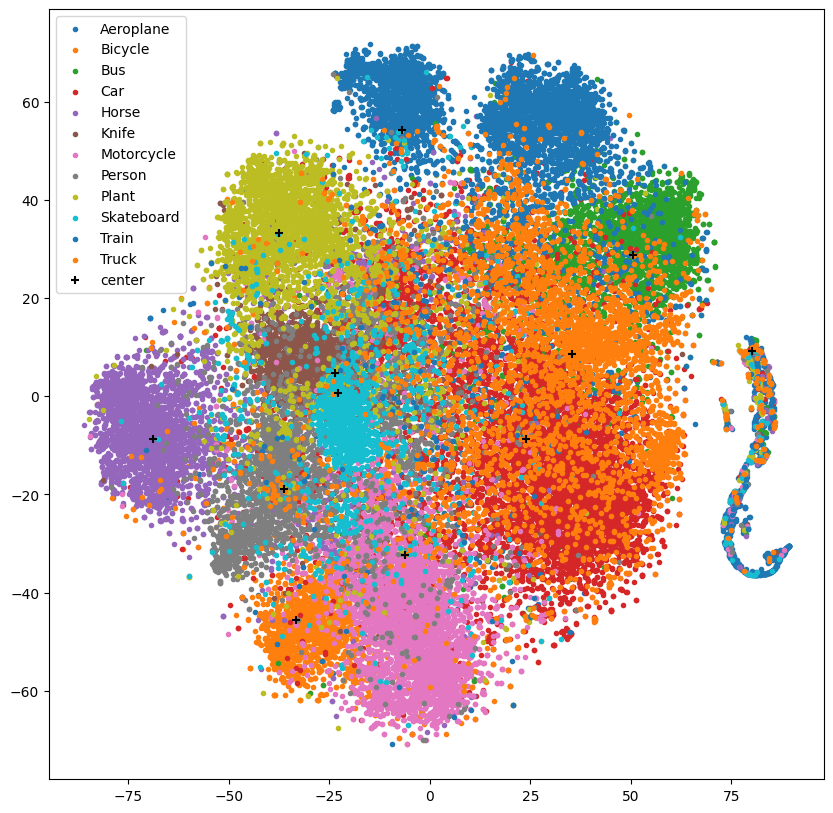

In [32]:
plt.figure(figsize=(10, 10))
class_name = ['Aeroplane', 'Bicycle', 'Bus', 'Car', 'Horse', 'Knife', 'Motorcycle', 'Person', 'Plant', 'Skateboard', 'Train', 'Truck', 'center']
for i, label in zip(range(len(class_name)), class_name):
    idx = np.where(c_gt == i)
    if i == 12: 
        plt.scatter(tsne_features[idx, 0], tsne_features[idx, 1], marker='+', label=label,c='black')
    else:
        plt.scatter(tsne_features[idx, 0], tsne_features[idx, 1], marker='.', label=label)
    

plt.legend()
plt.show()

In [90]:
center_point = center_tsne.fit_transform(center)
tsne_features = tsne.fit_transform(feature[:20000])

In [15]:
center_point = center_pca.fit_transform(center)
tsne_features = pca.fit_transform(feature[:20000])

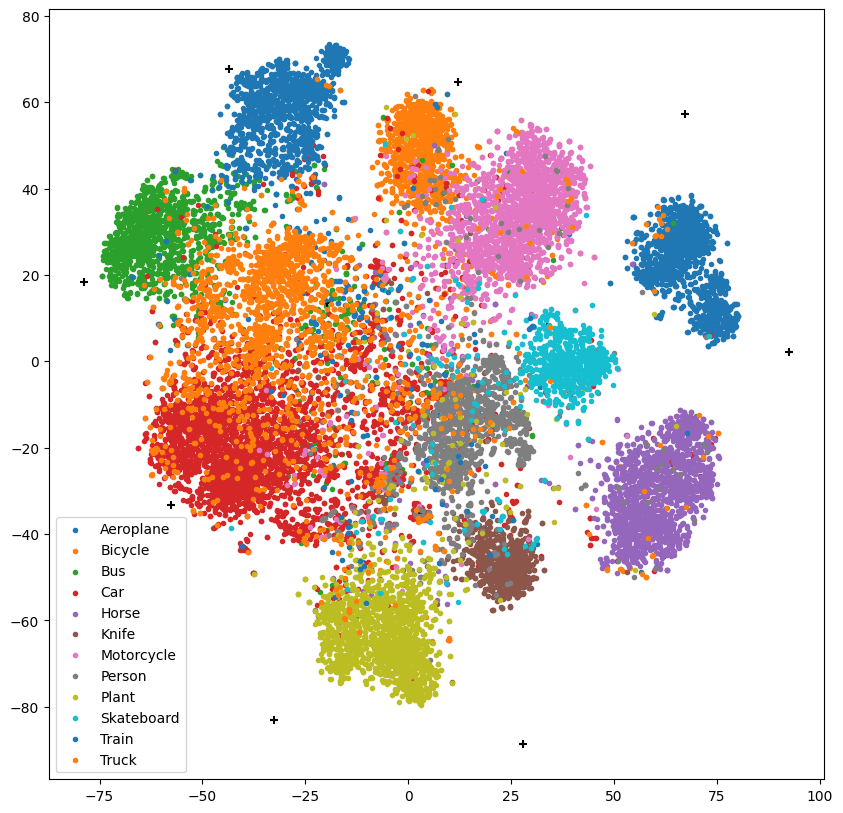

In [98]:

plt.figure(figsize=(10, 10))
class_name = ['Aeroplane', 'Bicycle', 'Bus', 'Car', 'Horse', 'Knife', 'Motorcycle', 'Person', 'Plant', 'Skateboard', 'Train', 'Truck']
for i, label in zip(range(len(class_name)), class_name):
    idx = np.where(gt[:20000] == i)
    plt.scatter(tsne_features[idx, 0], tsne_features[idx, 1], marker='.', label=label)
    plt.scatter(center_point[i][0],center_point[i][1],marker='+', c='black')

plt.legend()
plt.show()

In [99]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 61.4 MB/s eta 0:00:0031m93.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 40.2 MB/s eta 0:00:00m eta 0:00:010:0101
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 42.6 MB/s eta 0:00:00m eta 0:00:010:01:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=4ec6c5474bb18d15e1ad581d7fafbcf6858c92370ef65f7dc63da9bd753c78f4
  Stored in directory: /home/cmpark/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55623 sha256=f9865f9cda0b8b47ed146d7f118b893f39f15a69ce4b59ce6fd98fd26b9f6f16
  Stored in directory

In [105]:
!pip install numpy==1.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 32.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [3104 lines of output]
      Running from numpy source directory.
      blas_opt_info:
      blas_mkl_info:
      customize UnixCCompiler
        libraries mkl_rt not found in ['/opt/conda/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
        NOT AVAILABLE
      
      blis_info:
      customize UnixCCompiler
        libraries blis not found in ['/opt/conda/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
        NOT AVAILABLE
      
      openblas_info:
      customize UnixCCompiler
      customize UnixCCompiler
        libraries openblas not found in ['/opt/conda/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
        NOT AVAILABLE
  

In [106]:
import umap

_umap = umap.UMAP(n_components=2,random_state=42)
center_umap = umap.UMAP(n_components=2,random_state=42)



ImportError: Numba needs NumPy 1.24 or less

In [ ]:
from sklearn.manifold import TSNE # sklearn 사용하면 easy !! 
import numpy as np
from matplotlib import pyplot as plt

features_o = data['features_o'].cpu().numpy()[:10000]
tsne = TSNE(n_components=2, random_state=0) # 사실 easy 함 sklearn 사용하니..
cluster = np.array(tsne.fit_transform(features_o))
actual = np.array(data['gt'].cpu().numpy())[:10000]

In [8]:
pi = data['probs_o'].sum(dim=0)
mu = torch.matmul(data['probs_o'].t(), (data['features_o']))
mu = mu / pi.unsqueeze(dim=-1).expand_as(mu)
mu = mu.unsqueeze(0).to('cuda')

# input = data['features_o'].to('cuda')

In [ ]:
data['features_o']

In [7]:
from torch_clustering.torch_clustering import PyTorchGaussianMixture, evaluate_clustering

In [9]:
def plot(data, y):
    n = y.shape[0]

    fig, ax = plt.subplots(1, 1, figsize=(1.61803398875*4, 4))
    ax.set_facecolor("#bbbbbb")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # plot the locations of all data points ..
    for i, point in enumerate(data.data):
        if i <= n//2:
            # .. separating them by ground truth ..
            ax.scatter(*point, color="#000000", s=3, alpha=.75, zorder=n+i)
        else:
            ax.scatter(*point, color="#ffffff", s=3, alpha=.75, zorder=n+i)

        if y[i] == 0:
            # .. as well as their predicted class
            ax.scatter(*point, zorder=i, color="#dbe9ff", alpha=.6, edgecolors=colors[1])
        else:
            ax.scatter(*point, zorder=i, color="#ffdbdb", alpha=.6, edgecolors=colors[5])

    handles = [plt.Line2D([0], [0], color="w", lw=4, label="Ground Truth 1"),
        plt.Line2D([0], [0], color="black", lw=4, label="Ground Truth 2"),
        plt.Line2D([0], [0], color=colors[1], lw=4, label="Predicted 1"),
        plt.Line2D([0], [0], color=colors[5], lw=4, label="Predicted 2")]

    legend = ax.legend(loc="best", handles=handles)

In [13]:
kwargs = {
    'covariance_type':'diag',
    'metric': 'cosine',  # euclidean if not l2_normalize
    'distributed': False,
    'random_state': 0,
    'n_clusters': 12,
    'n_init' : 10,
    'max_iter': 20,
    'verbose': False
}

In [16]:
gmm = PyTorchGaussianMixture(**kwargs)

In [17]:
psedo_labels = gmm.fit_predict(input[:1000])

In [ ]:
class CenterGMM:
    def __init__(self, features, features_bank, probs_bank, args): 

        # cacluate uniform 
        clss_num = probs_bank.size(1)
        uniform = torch.ones(len(features),clss_num)/clss_num
        uniform = uniform.cuda()
    
        pi = probs_bank.sum(dim=0)
        mu = torch.matmul(probs_bank.t(),(features_bank)) ## matrix multiple (F,C)
        mu = mu / pi.unsqueeze(dim=-1).expand_as(mu)
        zz, gamma = gmm((features_bank), pi, mu, uniform)
        self.gamma = gamma
        
    def _step(self, features_bank): 
        pi = self.gamma.sum(dim=0)
        mu = torch.matmul(self.gamma.t(), (features_bank))
        mu = mu / pi.unsqueeze(dim=-1).expand_as(mu)

        zz, gamma = gmm((features), pi, mu, gamma)

In [ ]:
@torch.no_grad()
def torch_gmm_clustering(features, features_bank, probs_bank, args):
    # features # all current stack features (D, F)
    # features_bank # shuffling all features (D, F)
    # probs_bank # shuffling all pro b(D, C)
    
    
    clss_num = probs_bank.size(1)
    uniform = torch.ones(len(features),clss_num)/clss_num
    uniform = uniform.cuda()

    pi = probs_bank.sum(dim=0)
    mu = torch.matmul(probs_bank.t(),(features_bank)) ## matrix multiple (F,C)
    mu = mu / pi.unsqueeze(dim=-1).expand_as(mu)

    zz, gamma = gmm((features_bank), pi, mu, uniform)
    pred_labels = gamma.argmax(dim=1)
    
    for round in range(1):
        pi = gamma.sum(dim=0)
        mu = torch.matmul(gamma.t(), (features_bank))
        mu = mu / pi.unsqueeze(dim=-1).expand_as(mu)

        zz, gamma = gmm((features), pi, mu, gamma)
        pred_labels = gamma.argmax(axis=1)
            
    return pred_labels, None, None